In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
from sklearn.ensemble import RandomForestRegressor 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_1 = pd.read_csv('../data/preprocessed_data.csv')
df = df_1[:1000]
df = df.astype(float)
df.dropna(inplace=True) 
df.reset_index(drop=True, inplace=True)
label = 'price'
y = df[label]
X = df.drop(columns=[label])

In [3]:
def ML_pipeline_kfold(X, y, random_state, n_folds): 
    
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state) 
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state) 
    
    CV_scores = []
    r2score=[]
    best_parameters = [] 

    for train_index, CV_index in kf.split(X_other, y_other): 
        #X_train, X_CV = X_other[train_index], X_other[CV_index]
        #y_train, y_CV = y_other[train_index], y_other[CV_index]
        
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()] 
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()] 

        parameters = [(i, j) for i in [3,5,7,9] for j in [2,4,6,8,10]] 
        
        regs = []
        CV_score = []
        train_score = []

        for i, j in parameters: 
            reg = RandomForestRegressor(n_estimators=100, random_state=random_state, max_depth=i, min_samples_split=j) 
            reg.fit(X_train, y_train) 
        
            train_score.append(mean_squared_error(y_train,reg.predict(X_train)))
            CV_score.append(mean_squared_error(y_CV,reg.predict(X_CV)))
            regs.append(reg)
        
        best_i = parameters[np.argmin(CV_score)][0] 
        best_j = parameters[np.argmin(CV_score)][1]
        best_parameters.append((best_i, best_j)) 
        
        reg = regs[np.argmin(CV_score)]
        CV_scores.append(np.min(CV_score))
        
        r2score.append(reg.score(X_test,y_test))
        
        best_para = best_parameters[np.argmax(r2score)] 
        
    return best_para, min(CV_score), max(r2score), reg, X_test, y_test

In [4]:
test_scores_list = [] 
for i in range(10): 
    random_state = 23*(i+1)
    best_para, CV_score, r2_score, model, X_test_res, y_test_res = ML_pipeline_kfold_random_forest(X, y, random_state, 5) 
    test_scores_list.append(r2_score) 
    print('random state = {}. Best max_depth is {} & best min_samples_split is {}. r2_score is {}'.format(random_state, best_para[0], best_para[1], test_scores_list[-1])) 
average_list = np.mean(test_scores_list) 
std_list = np.std(test_scores_list)
print('average:', np.around(average_list,3))
print('std:', np.around(std_list,3))
print('test accuracy score:', np.around(average_list,3), '+/-', np.around(std_list,3))

random state = 23. Best max_depth is 9 & best min_samples_split is 4. r2_score is 0.26026539057545783
random state = 46. Best max_depth is 7 & best min_samples_split is 8. r2_score is 0.052155433112064276
random state = 69. Best max_depth is 9 & best min_samples_split is 8. r2_score is 0.1367031054730402
random state = 92. Best max_depth is 9 & best min_samples_split is 4. r2_score is 0.0627000164113759
random state = 115. Best max_depth is 9 & best min_samples_split is 2. r2_score is 0.34092660864792435
random state = 138. Best max_depth is 5 & best min_samples_split is 6. r2_score is 0.3719215805377275
random state = 161. Best max_depth is 7 & best min_samples_split is 6. r2_score is 0.41306390682743443
random state = 184. Best max_depth is 3 & best min_samples_split is 4. r2_score is 0.1251191572487772
random state = 207. Best max_depth is 9 & best min_samples_split is 10. r2_score is 0.07482714757613118
random state = 230. Best max_depth is 7 & best min_samples_split is 4. r2_score

In [5]:
import pickle
file = open('../results/model.save', 'wb')
pickle.dump((model,X_test_res, y_test_res), file)
file.close()

In [6]:
import pickle
file = open('../results/model.save', 'rb')
model, X_test_res, y_test_res = pickle.load(file)
file.close()

In [7]:
nr_runs = 10
ftr_names = X.columns
scores = np.zeros([len(ftr_names),nr_runs])

test_score = model.score(X_test_res, y_test_res)
#print('test score = ',test_score)
#print('test baseline = ',np.sum(test_y == 0)/len(test_y))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test_res.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_res[ftr_names[i]].values)
        acc_scores.append(model.score(X_test_shuffled,y_test_res))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

shuffling neighbourhood_group_Bronx
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_group_Brooklyn
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_group_Manhattan
   shuffled test score: 0.273 +/- 0.002
shuffling neighbourhood_group_Queens
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_group_Staten Island
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_Allerton
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_Arden Heights
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_Arrochar
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_Arverne
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_Astoria
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_Bath Beach
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_Battery Park City
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_Bay Ridge
   shuffled test score: 0.275 +/- 0.0
shuffling neighbourhood_Bay T

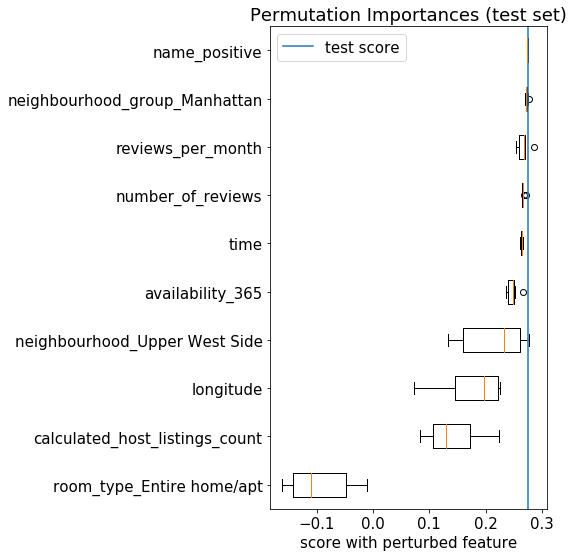

<Figure size 432x288 with 0 Axes>

In [8]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[:10]
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8,8))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('../figures/permutation_importance.png',dpi=100)